## Lecture: The (Py)Tesseract Library

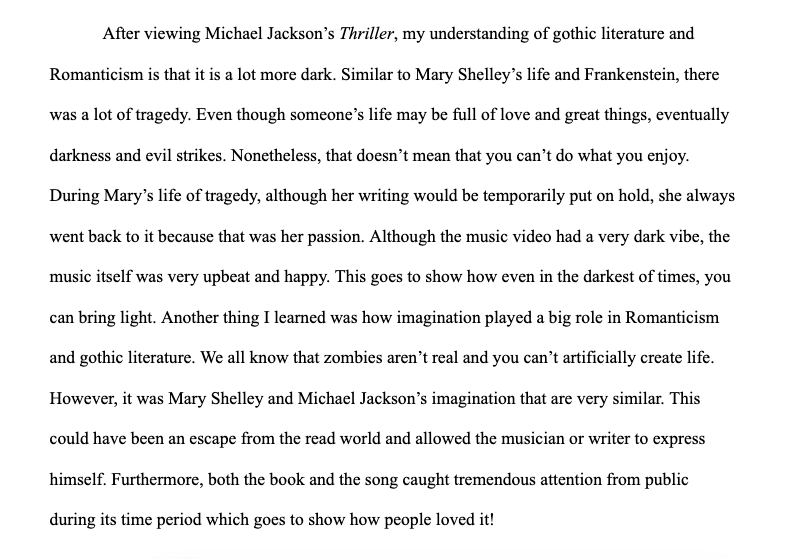

In [5]:
# We're going to start experimenting with tesseract using just a simple image of nice clean text.
# Lets first import Image from PIL and display the image text.png.
from PIL import Image

image = Image.open("/Users/malamapono/Desktop/text.png")
display(image)

In [6]:
# Great, we have a base image of some big clear text
# Lets import pytesseract and use the dir() fundtion to get a sense of what might be some interesting
# functions to play with
import pytesseract
dir(pytesseract)

['ALTONotSupported',
 'Output',
 'TSVNotSupported',
 'TesseractError',
 'TesseractNotFoundError',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'get_languages',
 'get_tesseract_version',
 'image_to_alto_xml',
 'image_to_boxes',
 'image_to_data',
 'image_to_osd',
 'image_to_pdf_or_hocr',
 'image_to_string',
 'pytesseract',
 'run_and_get_output']

In [7]:
# It looks like there are just a handful of interesting functions, and I think image_to_string
# is probably our best bet. Lets use the help() function to interrogate this a bit more 
help(pytesseract.image_to_string)

Help on function image_to_string in module pytesseract.pytesseract:

image_to_string(image, lang=None, config='', nice=0, output_type='string', timeout=0)
    Returns the result of a Tesseract OCR run on the provided image to string



In [8]:
# So this function takes an image as the first parameter, then there are a bunch of optional parameters,
# and it will return the results of the OCR. I think it's worth comparing this documentation string
# with the documentation we were receiving from the PILLOW module. Lets run the help command on the 
# Image resize function()
help(Image.Image.resize)

Help on function resize in module PIL.Image:

resize(self, size, resample=3, box=None, reducing_gap=None)
    Returns a resized copy of this image.
    
    :param size: The requested size in pixels, as a 2-tuple:
       (width, height).
    :param resample: An optional resampling filter.  This can be
       one of :py:data:`PIL.Image.NEAREST`, :py:data:`PIL.Image.BOX`,
       :py:data:`PIL.Image.BILINEAR`, :py:data:`PIL.Image.HAMMING`,
       :py:data:`PIL.Image.BICUBIC` or :py:data:`PIL.Image.LANCZOS`.
       Default filter is :py:data:`PIL.Image.BICUBIC`.
       If the image has mode "1" or "P", it is
       always set to :py:data:`PIL.Image.NEAREST`.
       See: :ref:`concept-filters`.
    :param box: An optional 4-tuple of floats providing
       the source image region to be scaled.
       The values must be within (0, 0, width, height) rectangle.
       If omitted or None, the entire source is used.
    :param reducing_gap: Apply optimization by resizing the image
       in two 

In [9]:
# Notice how the PILLOW function has a bit more information in it. First it's using a specific format
# called reStructuredText, which is similar in intent to document markups such as HTML, the language of
# the web. The intent is to embed semantics in the documentation itself. For instance, in the resize()
# function we see the words "param size" with colons surrounding it. This allows documentation engines
# which create web docs from source code to link the parameter to the extended docs about that parameter.
# In this case the extended docs tell us that the size should be passed as a tuple of width and height.
# Notice how the docs for image_to_string, for instance, indicate that there is a "lang" parameter we can
# use, but then fail to say anything about what that parameter is for or what its format is.
#
# What this really means is that we need to dig deeper. Here's a quick hack if you want to look at the
# source code of a function -- you can use the inspect getsource() command and print the results
import inspect
src = inspect.getsource(pytesseract.image_to_string)
print(src)

def image_to_string(
    image,
    lang=None,
    config='',
    nice=0,
    output_type=Output.STRING,
    timeout=0,
):
    """
    Returns the result of a Tesseract OCR run on the provided image to string
    """
    args = [image, 'txt', lang, config, nice, timeout]

    return {
        Output.BYTES: lambda: run_and_get_output(*(args + [True])),
        Output.DICT: lambda: {'text': run_and_get_output(*args)},
        Output.STRING: lambda: run_and_get_output(*args),
    }[output_type]()



In [11]:
# There's actually another way in jupyter, and that's to append *two* question marks to the end of
# a given function or module. Other editors have similar features, and is a great reason to use a 
# software development environment
pytesseract.image_to_string??

In [ ]:
# We can see from the source code that there really isn't much more information about what the parameters
# are for this image_to_string function. This is because underneath the pytesseract library is calling a C++
# library which does all of the hard work, and the author just passes through all of the calls to the 
# underlying tesseract executable. This is a common issue when working with python libraries, and it means
# we need to do some web sleuthing in order to understand how we can interact with tesseract.
#
# In a case like this I just googled "tesseract command line parameters" and the first hit was what I was
# looking for, here's the URL: https://tesseract-ocr.github.io/tessdoc/Command-Line-Usage
#
# This goes to a wiki page which describes how to call the tesseract executable, and as we read down we see
# that we can actually have tesseract use multiple languages in its detection, such as English and Hindi, by
# passing them in as "eng+hin". Very cool. 

In [12]:
# One last thing to mention - the image_to_string() function takes in an "image", but the docs don't
# really describe what this image is underneath. Is it a string to an image file? A PILLOW image?
# Something else?
#
# Again we have to sleuth (and/or experiment) to understand what we should do. If we look at the source
# code for the pytesseract library, we see that there is a function called run_and_get_output(). Here's
# a link to that function on the author's github account:
# https://github.com/madmaze/pytesseract/blob/d1596f7f59a517ad814b7d810ccdef7d33763221/src/pytesseract.py#L199
#
# In this function we see that one of the first things which happens is the image is saved through
# the save_image() function. Here's that line of code:
# https://github.com/madmaze/pytesseract/blob/d1596f7f59a517ad814b7d810ccdef7d33763221/src/pytesseract.py#L116
#
# And we see there that another function is called, prepare(image), which actually loads the image as a
# PILLOW image file. So yes, sending a PIL image file is appropriate use for this function! It sure would
# have been useful for the author to have included this information in reStructuredText to help us not have
# to dig through the implementation. But, this is an open source project -- maybe you would like to contribute
# back better documentation?
#
# Hint: The doc line we needed was :param image: A PIL Image.Image file or an ndarray of bytes
#
# In the end, we often don't do this full level of investigation, and we just experiment and try things. It
# seems likely that a PIL Image.Image would work, given how well known PIL is in the python world. But still,
# as you explore and use different libraries you'll see a breadth of different documentation norms, so it's
# useful to know how to explore the source code. And now that you're at the end of this course, you've got
# the skills to do so!
#
# Ok, lets try and run tesseract on this image
text = pytesseract.image_to_string(image)
print(text)

After viewing Michael Jackson’s Thriller, my understanding of gothic literature and
Romanticism is that it is a lot more dark. Similar to Mary Shelley’s life and Frankenstein, there
was a lot of tragedy. Even though someone’s life may be full of love and great things, eventually
darkness and evil strikes. Nonetheless, that doesn’t mean that you can’t do what you enjoy.
During Mary’s life of tragedy, although her writing would be temporarily put on hold, she always
went back to it because that was her passion. Although the music video had a very dark vibe, the
music itself was very upbeat and happy. This goes to show how even in the darkest of times, you
can bring light. Another thing I learned was how imagination played a big role in Romanticism
and gothic literature. We all know that zombies aren’t real and you can’t artificially create life.
However, it was Mary Shelley and Michael Jackson’s imagination that are very similar. This
could have been an escape from the read world and all

In [ ]:
# Looks great! We see that the output includes new line characters, and faithfully represents the text
# but doesn't include any special formatting. Lets go on and look at something with a bit more nuance to it.